In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

from utils.network import Sequential
import random

from gym.vector import SyncVectorEnv


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical, Normal

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device

'cuda'

In [3]:
# Hyperparameters
max_timesteps = 3000
n_epochs = 10
learning_rate = 0.0003
gamma = 0.99
eps_clip = 0.2
K_epochs = 4
action_std = 0.5
batch_size = 64
update_timestep = 2000

beta = 0.0

BEHAVIOR_DIM = 5

In [4]:
def compute_gae(done, rewards, values, next_values, gamma=0.99, lambda_=0.95):
    assert len(values) == len(next_values) == len(rewards) == len(done)

    advantages = torch.zeros(done.shape[0], dtype=torch.float32)
    returns = torch.zeros(done.shape[0], dtype=torch.float32)
    last_advantage = 0
    last_return = 0

    for t in reversed(range(done.shape[0])):
        mask = 1.0 - done[t]
        last_value = next_values[t] * mask
        last_advantage = last_advantage * mask
        last_return = last_return * mask

        delta = rewards[t] + gamma * last_value - values[t]
        last_advantage = delta + gamma * lambda_ * last_advantage
        last_return = rewards[t] + gamma * last_return

        advantages[t] = last_advantage
        returns[t] = last_return

    return advantages, returns

In [5]:
class ConditionedActorCriticContinuous(nn.Module):
    def __init__(self, descriptor_dim, state_dim, action_dim, actor_hidden_layers, critic_hidden_layers, action_std):
        super(ConditionedActorCriticContinuous, self).__init__()
        
        # Define actor network
        actor_layers = []
        input_dim = state_dim
        for hidden_dim in actor_hidden_layers:
            actor_layers.append(nn.Linear(input_dim, hidden_dim))
            actor_layers.append(nn.ReLU())
            input_dim = hidden_dim
        actor_layers.append(nn.Linear(input_dim, action_dim))
        # actor_layers.append(nn.Tanh())
        self.actor = nn.Sequential(*actor_layers)
        
        # Define critic network
        critic_layers = []
        input_dim = state_dim
        for hidden_dim in critic_hidden_layers:
            critic_layers.append(nn.Linear(input_dim, hidden_dim))
            critic_layers.append(nn.ReLU())
            input_dim = hidden_dim
        critic_layers.append(nn.Linear(input_dim, 1))
        self.critic = nn.Sequential(*critic_layers)
        
        self.action_var = nn.Parameter(torch.full((action_dim,), action_std**2, requires_grad=True))


    def forward(self, x, action=None):
        # print(f"{alpha.shape=}")

        action_mean = self.actor(x)
        cov_matrix = torch.exp(self.action_var)
        dist = Normal(loc=action_mean, scale=cov_matrix)
        
        if action is None:
            action = dist.sample()
            
        log_p = dist.log_prob(action).sum(dim=-1)
        
        value = self.critic(x)
                
        return action, action_mean, log_p, value, dist.entropy()

In [6]:
def get_descriptor(info):
    d1 = np.mean([d1 for (d1, d2) in info])
    d2 = np.mean([d2 for (d1, d2) in info])
    return d1, d2
    # return np.mean(info['bfoot_touch_ground']), np.mean(info['ffoot_touch_ground'])
    
    
def get_descriptors_from_trajectories(data):
    
    num_envs = data['info'].shape[0]
    
    descriptors = []
    for n in range(num_envs):
        env_n_descriptors = []
        trajectory_info = []
        for i in range(len(data['info'][n])):
            # print(i)
            trajectory_info.append(data['info'][n][i])
            
            if data['done'][n][i] == True:
                d1, d2 = get_descriptor(trajectory_info)
                # d1, d2 = round(d1*BEHAVIOR_DIM), round(d2*BEHAVIOR_DIM)
                descriptors.append((d1, d2))
        
        # descriptors.append(env_n_descriptors)
        
    return descriptors




def descriptors_to_vectors(descriptors):
    vectors = []
    for (d1, d2) in descriptors:
        vector = [0]*(BEHAVIOR_DIM**2)
        vector[d1*BEHAVIOR_DIM+d2] = 1
        vectors.append(vector)
    return vectors

def descriptors_to_id(descriptors):
    ids = []
    for (d1, d2) in descriptors:
        ids.append(d1*BEHAVIOR_DIM+d2)
    return ids

def descriptors_vec2coord(descriptors):
    d_id = descriptors.argmax(axis=1)
    d1, d2 = d_id // BEHAVIOR_DIM, d_id % BEHAVIOR_DIM
    return torch.concat((d1.unsqueeze(0), d2.unsqueeze(0))).t().float() / BEHAVIOR_DIM

In [7]:
def random_descriptors(n):
    descriptors = torch.zeros((n, BEHAVIOR_DIM**2), dtype=torch.float32)
    for i in range(n):
        descriptors[i, torch.randint(0, BEHAVIOR_DIM**2, size=(1,))] = 1.
    return descriptors

In [8]:
def post_process(action):
    return torch.tanh(action)

In [9]:
def collect_trajectories(env, model, condition_descriptor, n_steps: int):
    
    states = np.zeros((env.num_envs, n_steps, env.single_observation_space.shape[0]), dtype=np.float32)
    actions = np.zeros((env.num_envs, n_steps, env.single_action_space.shape[0]), dtype=np.float32)
    rewards = np.zeros((env.num_envs, n_steps), dtype=np.float32)
    log_ps = np.zeros((env.num_envs, n_steps), dtype=np.float32)
    state_values = np.zeros((env.num_envs, n_steps), dtype=np.float32)
    dones = np.zeros((env.num_envs, n_steps), dtype=np.float32)
    info = np.zeros((env.num_envs, n_steps, 2), dtype=np.float32)
    
    advantages = np.zeros((env.num_envs, n_steps), dtype=np.float32)

    state, _ = env.reset()
    

    total_reward = 0
    step_count = 0

    for s in range(n_steps):
        state = torch.FloatTensor(state).to(device)
        # print(state.shape, alpha.shape)
        with torch.no_grad():
            action, action_mean, log_p, state_value, entropy = model(state)
        next_state, reward, terminated, truncated, _ = env.step(post_process(action).cpu().tolist())
        done = (terminated | truncated)
        
        states[:, s] = state.cpu()
        actions[:, s] = action.cpu()
        rewards[:, s] = reward
        log_ps[:, s] = log_p.cpu().detach().numpy()
        state_values[:, s] = state_value.cpu().detach().reshape(-1).numpy()
        dones[:, s] = done
        info[:, s] = [(int(5 in env_.data.contact.geom2), int(8 in env_.data.contact.geom2)) for env_ in env.envs]        

        state = next_state
        # total_reward += reward
        # step_count += 1

        if done.any():
            # state, _ = env.reset(np.where(dones)[0])
            state, _ = env.reset()
    
    
    
    condition_descriptor_coord = descriptors_vec2coord(condition_descriptor)
    achieved_descriptors = get_descriptors_from_trajectories({'info': info, 'done': dones})
    achieved_descriptors = torch.tensor(achieved_descriptors).to(device)
    
    
    # Calculate the distance between the goal descriptor and the achieved descriptor:
    # print(achieved_descriptors, condition_descriptor_coord)
    # descriptors_similarity = ((condition_descriptor_coord - achieved_descriptors)**2).sum(axis=-1)
    # descriptors_similarity = torch.exp(-descriptors_similarity/0.1)
    
    # descriptors_similarity = achieved_descriptors.mean(-1)
    descriptors_similarity = achieved_descriptors[:, 1]
    
    similarity_reward = descriptors_similarity.unsqueeze(1).repeat(1, n_steps).cpu()
    
    
    critic_x = torch.FloatTensor(next_state).to(device)
    next_value = model.critic(critic_x).cpu()    
    
        
    states = torch.tensor(states)
    actions = torch.tensor(actions)
    real_rewards = torch.tensor(rewards)
    rewards = similarity_reward
    # rewards = real_rewards
    # rewards = (10+real_rewards) * similarity_reward
    
    log_ps = torch.tensor(log_ps)
    state_values = torch.tensor(state_values)
    dones = torch.tensor(dones)
    next_state_values = torch.concatenate((state_values[:, 1:], next_value), dim=-1)
    

    advantages, returns = [], []
    for i in range(env.num_envs):
        a, r = compute_gae(dones[i], rewards[i], state_values[i], next_state_values[i])
        advantages.append(a)
        returns.append(r)
    advantages = torch.stack(advantages)
    returns = torch.stack(returns)

    # print(condition_descriptor_coord)
    # print(achieved_descriptors)
    # print(rewards)
    # print(advantages)
    # print(returns)
    # return 
    
    trajectories = {
        "descriptors": condition_descriptor.unsqueeze(1).repeat(1, n_steps, 1).reshape(-1, BEHAVIOR_DIM**2),
        "states" :  states.reshape(-1, env.single_observation_space.shape[0]).detach(),
        "actions" : actions.reshape(-1, env.single_action_space.shape[0]).detach(),
        "rewards" : rewards.reshape(-1).detach(),
        "dones" : dones.reshape(-1).detach(),
        "log_ps" : log_ps.reshape(-1).detach(),
        "state_values": state_values.reshape(-1).detach(),
        "next_state_values": next_state_values.reshape(-1).detach(),
        "returns" : returns.reshape(-1).detach(),
        "advantages" : advantages.reshape(-1).detach(),
    }

    return trajectories, {
        'info':info, 'done':dones, 
        'reward': rewards, 'real_reward': real_rewards, 
        'similarity': similarity_reward
    }


def shufffle_trajectory(trajectories):
    length = trajectories['states'].shape[0]
    permutation = torch.randperm(length)

    shuffled_trajectories = {key: tensor[permutation] for key, tensor in trajectories.items()}
    return shuffled_trajectories

In [10]:
# trajectory, info = collect_trajectories(env, model, condition_descriptors, n_steps=max_episode_steps)

In [11]:
def ppo_optimization(trajectories, model, optimizer, epochs, batch_size):
    
    model.train()
    
    traj_descriptors = trajectories["descriptors"]
    traj_states = trajectories["states"]
    traj_actions = trajectories["actions"]
    traj_log_ps = trajectories["log_ps"]
    traj_returns = trajectories["returns"]  
    traj_advantages = trajectories["advantages"]


    len_trajectory = traj_states.shape[0]

    for epoch in range(1, epochs+1):
        for i in range(len_trajectory // batch_size):
            alpha = traj_descriptors[batch_size*i:batch_size*(i+1)].to(device)
            state = traj_states[batch_size*i:batch_size*(i+1)].to(device)
            action = traj_actions[batch_size*i:batch_size*(i+1)].to(device)
            log_p = traj_log_ps[batch_size*i:batch_size*(i+1)].to(device)
            return_ = traj_returns[batch_size*i:batch_size*(i+1)].to(device)
            advantage = traj_advantages[batch_size*i:batch_size*(i+1)].to(device)
                        
            # print(alpha)
            new_action, new_action_mean, new_log_p, new_state_value, entropy = model(state, action)
            assert(new_action == action).all()
            
            
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

            new_log_p, log_p, advantage = new_log_p.reshape(-1), log_p.reshape(-1), advantage.reshape(-1)
            
            ratio = torch.exp(new_log_p - log_p.detach())
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-0.2, 1+0.2) * advantage
            policy_loss = - torch.min(surr1, surr2).mean()
            
            # print(policy_loss)
            
            
            return_, new_state_value = return_.reshape(-1), new_state_value.reshape(-1)
            critic_loss = ((return_ - new_state_value)**2).mean()
        

            loss = policy_loss - 2e-7*entropy.mean() + 0.5*critic_loss

            optimizer.zero_grad()
            loss.backward()
            clip_factor = torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

# ppo_optimization(trajectories, model, optimizer, epochs=1, batch_size=5)
# ppo_optimization(shuffled_trajectory, model, alpha, optimizer, epochs=5, batch_size=256)

In [12]:
def evaluate(env, model, descriptor):
    model.eval()

    state, _ = env.reset()
        
    total_reward = 0
    step_count = 0

    trajectory = []
    info = []
    

    while True:
        trajectory.append(state)
        state = torch.FloatTensor(state).to(device).unsqueeze(0)
        with torch.no_grad():
            action, mean_action, log_p, state_value, entropy = model(state)
        next_state, reward, terminated, truncated, _ = env.step(post_process(action)[0].cpu().tolist())

        info.append((
            int(5 in env.data.contact.geom2), int(8 in env.data.contact.geom2)
        ))
        
        done = terminated or truncated

        state = next_state
        total_reward += reward
        step_count += 1
        
        
        if done:
            break
        
    return total_reward, trajectory, info


def get_reward_from_trajectory(info):
    reward_list = []
    real_reward_list = []
    sim_list = []
    acc_reward = 0
    acc_real_reward = 0
    acc_similarity = 0
    for n in range(len(info['reward'])):
        for i in range(len(info['reward'][n])):
            if info['done'][n][i] == True:
                reward_list.append(acc_reward)
                real_reward_list.append(acc_real_reward)
                sim_list.append(info['similarity'][n][-1])
                acc_reward = 0
                acc_real_reward = 0
                acc_similarity = 0
            
            acc_reward += info['reward'][n][i]
            acc_real_reward += info['real_reward'][n][i]
            acc_similarity += info['similarity'][n][i]

    return np.mean(reward_list), np.mean(real_reward_list), np.mean(sim_list)

In [13]:
# env = gym.vector.make('HalfCheetah-v4', render_mode = "rgb_array", num_envs=8)

max_episode_steps = 1000
num_envs = 8
env_fns = [lambda: gym.make('HalfCheetah-v4', render_mode="rgb_array", max_episode_steps=max_episode_steps) for _ in range(num_envs)]
env = gym.vector.SyncVectorEnv(env_fns)

state_dim = env.observation_space.shape[-1]
action_dim = env.action_space.shape[-1]


In [14]:
model = ConditionedActorCriticContinuous(
    BEHAVIOR_DIM**2,
    state_dim,
    action_dim,
    actor_hidden_layers=[256, 256],
    critic_hidden_layers=[256, 256],
    action_std=0.5
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003)


rewards, real_rewards, similarities = [], [], []
all_descriptors = []
all_condition_descriptors = []

H_d_a_list = []
H_d_list = []
cross_entropies = []
diversity_lossses = []

tqdm_epochs = tqdm(range(1, 2000+1))
for epochs in tqdm_epochs:
    
    for _ in range(1):
        # condition_descriptors = random_descriptors(env.num_envs).to(device)
        condition_descriptors = torch.tensor(descriptors_to_vectors([(4,4)]), dtype=torch.float32).repeat(env.num_envs, 1).to(device)
        trajectory, info = collect_trajectories(env, model, condition_descriptors, n_steps=max_episode_steps)
        descriptors = get_descriptors_from_trajectories(info)
        
        all_condition_descriptors += condition_descriptors.tolist()
        all_descriptors += descriptors
        print(descriptors)

    shuffled_trajectory = shufffle_trajectory(trajectory)
    diversity_loss = ppo_optimization(shuffled_trajectory, model, optimizer, epochs=4, batch_size=512)
    diversity_lossses.append(diversity_loss)
    
    final_reward, final_real_reward, final_similarity = get_reward_from_trajectory(info)
    rewards.append(max(final_reward, -3000))
    real_rewards.append(max(final_real_reward, -3000))
    similarities.append(final_similarity)
    
    tqdm_epochs.set_description(f'Reward: {final_reward:.2f}')
    
    
    if epochs % 10 == 0:
        clear_output(True)
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].plot(rewards)
        axes[0].set_title('Rewards')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Reward')
        
        axes[1].plot(real_rewards)
        axes[1].set_title('Real Rewards')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Real Reward')
        
        axes[2].plot(similarities)
        axes[2].set_title('Similarities')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('Similarity')

        # Display the plots
        plt.tight_layout()
        plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]/home/nazim/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


[(0.071, 0.108), (0.126, 0.308), (0.141, 0.288), (0.004, 0.019), (0.126, 0.324), (0.131, 0.31), (0.019, 0.045), (0.143, 0.293)]


Reward: 211.84:   0%|          | 1/2000 [00:02<1:09:16,  2.08s/it]

[(0.128, 0.271), (0.024, 0.045), (0.153, 0.296), (0.069, 0.077), (0.137, 0.2), (0.011, 0.038), (0.147, 0.321), (0.161, 0.294)]


Reward: 192.71:   0%|          | 2/2000 [00:03<58:06,  1.75s/it]  

[(0.102, 0.237), (0.163, 0.296), (0.069, 0.247), (0.123, 0.268), (0.108, 0.353), (0.164, 0.286), (0.117, 0.23), (0.161, 0.28)]


Reward: 239.59:   0%|          | 4/2000 [00:06<52:03,  1.57s/it]

[(0.136, 0.35), (0.113, 0.359), (0.035, 0.168), (0.172, 0.273), (0.045, 0.085), (0.115, 0.342), (0.01, 0.039), (0.151, 0.301)]
[(0.022, 0.034), (0.032, 0.108), (0.047, 0.081), (0.126, 0.318), (0.017, 0.029), (0.183, 0.292), (0.132, 0.366), (0.143, 0.199)]


Reward: 178.35:   0%|          | 5/2000 [00:08<50:46,  1.53s/it]

[(0.046, 0.095), (0.052, 0.065), (0.035, 0.115), (0.013, 0.024), (0.077, 0.136), (0.164, 0.29), (0.028, 0.046), (0.133, 0.334)]


Reward: 138.08:   0%|          | 6/2000 [00:09<50:06,  1.51s/it]

[(0.017, 0.015), (0.101, 0.28), (0.025, 0.087), (0.113, 0.27), (0.17, 0.296), (0.17, 0.275), (0.109, 0.187), (0.01, 0.022)]


Reward: 179.00:   0%|          | 7/2000 [00:10<49:31,  1.49s/it]

[(0.065, 0.114), (0.154, 0.234), (0.006, 0.012), (0.136, 0.257), (0.005, 0.014), (0.155, 0.273), (0.016, 0.044), (0.002, 0.021)]


Reward: 121.12:   0%|          | 8/2000 [00:13<54:04,  1.63s/it]


KeyboardInterrupt: 

In [ ]:
model.action_var

Parameter containing:
tensor([ 0.1689,  0.1139,  0.2189, -0.2254, -0.2242,  0.1445], device='cuda:0',
       requires_grad=True)

(array([   15.,   224.,  1702.,  6327., 11762., 14949., 10110.,  2552.,
          327.,    32.]),
 array([-5.61361074, -4.49538326, -3.37715578, -2.25892806, -1.14070058,
        -0.0224731 ,  1.09575438,  2.21398187,  3.33220959,  4.45043707,
         5.56866455]),
 <BarContainer object of 10 artists>)

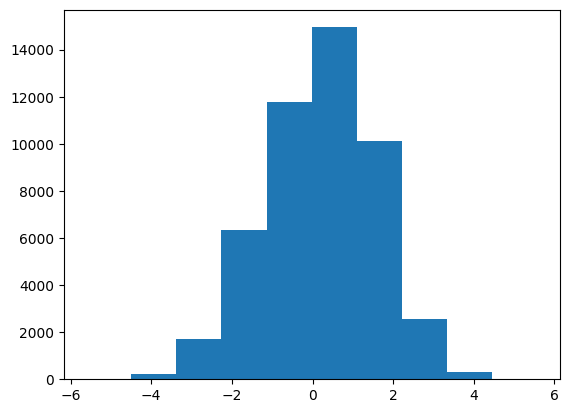

In [ ]:
plt.hist(trajectory['actions'].reshape(-1))

In [ ]:
trajectory['states'][0]

tensor([ 0.0702,  0.0623,  0.0305,  0.0386,  0.0350,  0.0269, -0.0184, -0.0036,
         0.0552,  0.0692,  0.0946,  0.0280, -0.0460, -0.1589, -0.0833, -0.0471,
        -0.0561])

In [ ]:
get_reward_from_trajectory(info)

(0.606151, -1141.6158, 3.8897888e-05)

In [ ]:
trajectory['rewards'].reshape(8, -1)

tensor([[0.0052, 0.0052, 0.0052,  ..., 0.0052, 0.0052, 0.0052],
        [0.0095, 0.0095, 0.0095,  ..., 0.0095, 0.0095, 0.0095],
        [0.0073, 0.0073, 0.0073,  ..., 0.0073, 0.0073, 0.0073],
        ...,
        [0.0058, 0.0058, 0.0058,  ..., 0.0058, 0.0058, 0.0058],
        [0.0052, 0.0052, 0.0052,  ..., 0.0052, 0.0052, 0.0052],
        [0.0093, 0.0093, 0.0093,  ..., 0.0093, 0.0093, 0.0093]])

In [ ]:
info['similarity']

tensor([[0.0052, 0.0052, 0.0052,  ..., 0.0052, 0.0052, 0.0052],
        [0.0095, 0.0095, 0.0095,  ..., 0.0095, 0.0095, 0.0095],
        [0.0073, 0.0073, 0.0073,  ..., 0.0073, 0.0073, 0.0073],
        ...,
        [0.0058, 0.0058, 0.0058,  ..., 0.0058, 0.0058, 0.0058],
        [0.0052, 0.0052, 0.0052,  ..., 0.0052, 0.0052, 0.0052],
        [0.0093, 0.0093, 0.0093,  ..., 0.0093, 0.0093, 0.0093]])

In [ ]:
torch.save(model.state_dict(), 'models/cond(4,4).pt')

---

In [ ]:
# model = ActorCriticContinuous(
#     1,
#     state_dim,
#     action_dim,
#     same_init=True,
#     actor_hidden_layers=[256, 256],
#     critic_hidden_layers=[256, 256],
#     action_std=0.5
# ).to(device)

# model.load_state_dict(torch.load('models/halfcheetah/n_anchors=1.pt'))

In [ ]:
single_env = gym.make('HalfCheetah-v4', render_mode="rgb_array", max_episode_steps=max_episode_steps)

descriptors = []
desc_rewards = []

for _ in tqdm(range(100)):
    reward, states, info = evaluate(single_env, model, random_descriptors(1).to(device))
    descriptors.append(get_descriptor(info))
    rewards.append(reward)
    
descriptors_array = np.array(descriptors)

  0%|          | 0/100 [00:00<?, ?it/s]/home/nazim/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


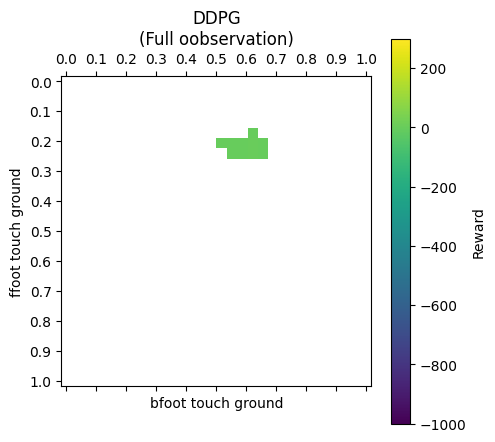

In [ ]:
import matplotlib.pyplot as plt

x1, x2 = 0, 1

x1_min = 0
x1_max = 1
x2_min = 0
x2_max = 1

N = 30

x1_bins = np.linspace(x1_min, x1_max, N)
x2_bins = np.linspace(x2_min, x2_max, N)

map_grid = np.full((N, N), np.nan)


def get_bin(value, bins):
    return np.digitize(value, bins) - 1


for descriptor, reward in zip(descriptors, rewards):
    feature1, feature2 = descriptor[x1], descriptor[x2]
    f1_bin = get_bin(feature1, x1_bins)
    f2_bin = get_bin(feature2, x2_bins)
    
    if np.isnan(map_grid[f1_bin, f2_bin]):
        map_grid[f1_bin][f2_bin] = reward
    else:
        map_grid[f1_bin][f2_bin] = max(map_grid[f1_bin][f2_bin], reward) 


fig, axs = plt.subplots(1, 1, figsize=(5,5))


cax = axs.matshow(map_grid, cmap="viridis", vmin=-1000, vmax=300)
axs.set_title('DDPG\n(Full oobservation)', loc='center')

axs.set_xlabel('bfoot touch ground')
axs.set_ylabel('ffoot touch ground')
axs.set_xticks(np.linspace(0, N-1, num=11))
axs.set_xticklabels(np.round(np.linspace(0, 1, num=11), 2))
axs.set_yticks(np.linspace(0, N-1, num=11))
axs.set_yticklabels(np.round(np.linspace(0, 1, num=11), 2))
    
fig.colorbar(cax, ax=axs, orientation='vertical', label='Reward')
plt.show()

In [ ]:
model = ActorCriticContinuous(
    1,
    state_dim,
    action_dim,
    same_init=False,
    actor_hidden_layers=[256, 256],
    critic_hidden_layers=[256, 256],
    action_std=0.5
).to(device)

model.load_state_dict(torch.load('models/halfcheetah/n_anchors=1.pt'))


NameError: name 'ActorCriticContinuous' is not defined

In [ ]:
import gym

In [16]:
one_env = gym.make('HalfCheetah-v4', render_mode="rgb_array", max_episode_steps=100)

In [18]:
from time import sleep

# alpha = torch.tensor([0.5.]).to(device)

state, _ = one_env.reset()
total_reward = 0
tqdm_range = tqdm(range(max_timesteps))
for t in tqdm_range:
    state = torch.FloatTensor(state).to(device)
    with torch.no_grad():
        action, _, log_p, state_value, entropy = model(state)
    # action = torch.normal(0, 1, size=(action.shape))
    next_state, reward, terminated, truncated, _ = one_env.step(post_process(action)[0].cpu().tolist())
    done = terminated or truncated
    
    # Add data to memory
    # memory.add(state, action, reward, action_logprob, done)
    state = next_state
    total_reward += reward
    
    clear_output(True)
    frame = one_env.render()
    plt.imshow(frame)
    plt.show()
    
    # print(env.get_body_com('ffoot'))
    # print(env.data.body('bfoot').cfrc_int, env.data.body('ffoot').cfrc_int)
    
    
    # print(env.data.body('ffoot').xipos)
    # print(env.data.body('bfoot').cfrc_ext.any(), env.data.body('ffoot').cfrc_ext.any())
    # print(env.data.contact)
    print(5 in one_env.data.contact.geom2, 8 in one_env.data.contact.geom2)
    
    # if env.data.contact.H.shape[0] != 0:
        # break
    
    if done:
        break
    
    # sleep(1)
    
print(total_reward)

  0%|          | 0/3000 [00:00<?, ?it/s]


ValueError: Action dimension mismatch

In [ ]:
env.data.contact.geom2

array([5, 8], dtype=int32)

In [ ]:
env.data.body

<bound method PyCapsule.body of <mujoco._structs.MjData object at 0x754a173cd070>>

In [ ]:
env.data.body('ffoot').cfrc_int

array([  0.        ,  22.1293691 ,   0.        , -52.90674133,
         0.        , -13.8416032 ])

In [ ]:
env.data.body('bfoot').cfrc_int

array([  0.        , -65.58391056,   0.        , 124.25011867,
         0.        , -41.76418074])

In [ ]:
env.data.body('bfoot')

<_MjDataBodyViews
  cacc: array([   0.        , -731.05017666,    0.        ,  -51.67292521,
          0.        ,  575.00922327])
  cfrc_ext: array([0., 0., 0., 0., 0., 0.])
  cfrc_int: array([  0.        , -65.58391056,   0.        , 124.25011867,
         0.        , -41.76418074])
  cinert: array([ 0.05770359,  0.76445357,  0.70785189,  0.        , -0.19661607,
        0.        , -0.87857201,  0.        , -0.24193659,  1.09539749])
  crb: array([ 0.05770359,  0.76445357,  0.70785189,  0.        , -0.19661607,
        0.        , -0.87857201,  0.        , -0.24193659,  1.09539749])
  cvel: array([ 0.        ,  7.11009233,  0.        ,  5.33851089,  0.        ,
       -5.19108022])
  id: 4
  name: 'bfoot'
  subtree_angmom: array([0., 0., 0.])
  subtree_com: array([2.04672575, 0.        , 0.42603072])
  subtree_linvel: array([0., 0., 0.])
  xfrc_applied: array([0., 0., 0., 0., 0., 0.])
  ximat: array([ 0.77652312,  0.        ,  0.63008876,  0.        ,  1.        ,
        0.        

In [ ]:
from datetime import datetime
now = datetime.now()
formatted_time = now.strftime("%d/%m/%Y-%H:%M:%S")
formatted_time

'03/11/2024-21:15:50'

In [ ]:
datetime.now

AttributeError: module 'datetime' has no attribute 'now'